# Riemannian Regression

> **_Tip:_** Launch live version of this tutorial: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/morphomatics/morphomatics.github.io/HEAD?filepath=docs%2Ftutorials%2Ftutorial_regression.ipynb)

Regression analysis is a reliable statistical approach to estimate the relationship between observed variables, e.g. shapes, and their co-varying parameters.
For geometric data we again required intrinsic approaches that account for and fully leverage the geometry of the data space.
The most widely used is to approximate the observed temporal shape data by geodesics, i.e. generalized straight lines.
Geodesic models are attractive as they feature a compact representation (similar to the slope and intercept term in linear regression) and therefore allow for computationally efficient inference.
However, non-monotonous shape changes, e.g. present in time-series of cardiac shape motion or anatomical changes in the human brain over the course of decades, do generally not adhere to constraints of geodesicity.

_Morphomatics_ provides nonlinear regression for manifold-valued (in particular shape) data based on Riemannian spline models.
This framework is very flexible allowing to model geodesics, generalized polynomials, and Bézier splines (possibly closed).
Employing constructive algorithms the provided models still allow for efficient and exact evaluation.

## Least squares estimation

Every Riemannian manifold $M$ (in particular a manifold of shapes) comes with a distance function $d$. Given parameter-data pairs $(t_1, p_1),\dots,(t_n,p_n) \in \mathbb{R} \times M$ a widely used notion
to measure how well a (parametrized) curve $\alpha$ estimates the data is the sum-of-squared error

$$
\mathcal{E}(\alpha) := \sum_{i=1}^n \text{dist}_M^2(\alpha(t_i), p_i),
$$

that is, the sum of the squared distances from the curve to the data points.
A minimizer of $\mathcal{E}$ (from a class of trajectories) is called least-squares estimator of the data (in this class).

## Geodesic regression

Generalizing the linear ansatz, _geodesic regression_ assumes that the relationship of a manifold-valued observed variable and a (single) co-varying parameter is well approximated by a generalized straight line.
It is thus estimated by the geodesic least-squares estimator. The following example for data from the manifold of 3x3 rotation matrices shows how geodesic regression is computed in Morphomatics.

In [3]:
%env JAX_PLATFORM_NAME=cpu

import jax
import jax.numpy as jnp
from scipy.spatial.transform import Rotation

from morphomatics.manifold import SO3
from morphomatics.stats import RiemannianRegression

"""Geodesic regression for data in SO(3)"""

# space of rotations in 3-dim. space
M = SO3()

# 0° rotation
I = M.group.identity
# 30° rotation around z-axis
R = jnp.asarray([Rotation.from_rotvec([0, 0, jnp.pi / 6]).as_matrix()])

# generate 6 points in SO(3) (by perturbing pts. along geodesic passing through I and R)
eval_perturbed = lambda t, vec: M.connec.exp(M.connec.geopoint(I,R,t), vec)
Y = jnp.array([
    eval_perturbed(-2 / 3, jnp.array([[[0, 0, 0.1], [0, 0, 0], [-0.1, 0, 0]]])),
    eval_perturbed(-1 / 3, jnp.array([[[0, 0, 0], [0, 0, 0.2], [0, -0.2, 0]]])),
    I,
    eval_perturbed(1 / 3, jnp.array([[[0, 0, 0], [0, 0, 0.2], [0, -0.2, 0]]])),
    eval_perturbed(2 / 3, jnp.array([[[0, 0, 0.1], [0, 0, 0], [-0.1, 0, 0]]])),
    R
])

# corresponding time points
t = jnp.array([0, 1/5, 2/5, 3/5, 4/5, 1])

# specify degree of fitted curve (1 -> geodesic)
degree = 1

# solve
regression = RiemannianRegression(M, Y, t, degree)

# geodesic least-squares estimator
gam = regression.trend

env: JAX_PLATFORM_NAME=cpu


To visualize the regressed geodesic, the 100 rotation matrices that were sampled from it as well as the 6 data matrices
were applied to the vector $q=\begin{bmatrix} 1 & 0 & 0 \end{bmatrix}^T$. The results all lie on the unit sphere;
they are shown in the following image.

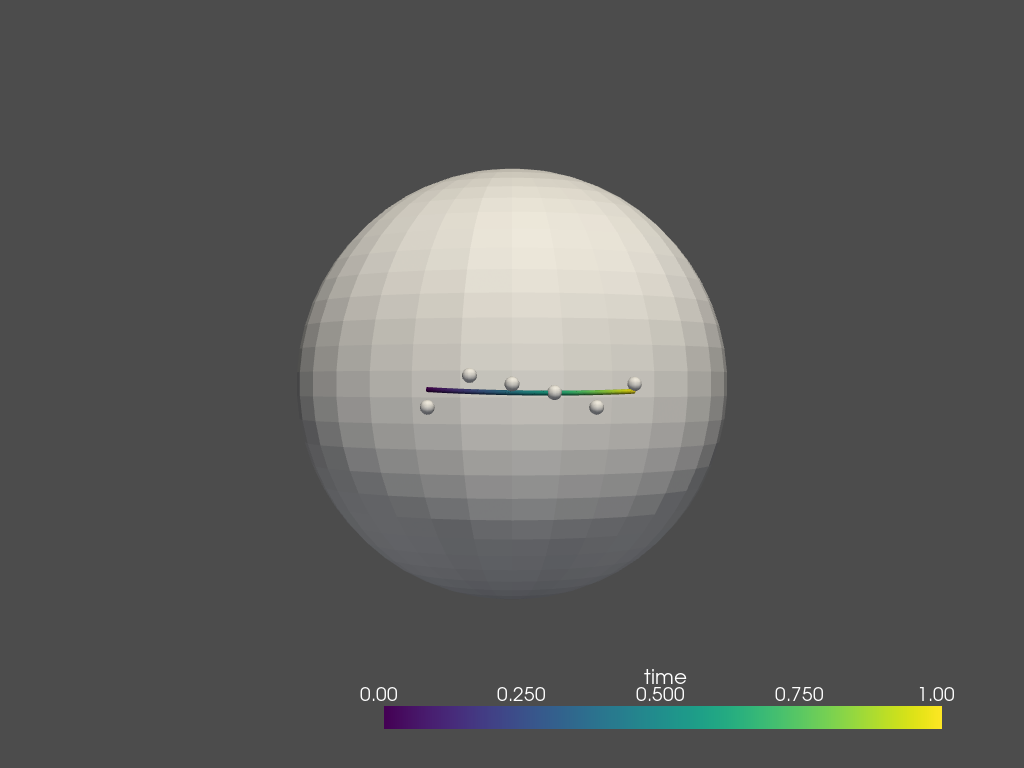

In [4]:
import pyvista as pv
import numpy as np

# evaluate geodesic at 100 equidistant points
X = jax.vmap(gam.eval)(jnp.linspace(0., 1., num=100))

# rotate [1,0,0] by rotations in X, i.e. take first column of X
x = np.asarray(X[...,0].squeeze())

# create a tubular surface interpolating points
def tube_mesh(pts, interval=(0,1)):
    n = len(pts)-1
    curve = pv.PolyData(pts)
    curve["time"] = np.linspace(*interval, curve.n_points)
    curve.lines = np.c_[np.full(n,2), np.arange(n), np.arange(n)+1]
    curve.tube(radius=0.01, inplace=True)
    return curve

# plot curve on sphere
pl = pv.Plotter(notebook=True)
pl.add_mesh(tube_mesh(x))
pl.add_mesh(pv.Sphere(1))

# plot data Y (i.e. their action on [1,0,0])
for y in Y:
    pl.add_mesh(pv.Sphere(radius=0.03, center=y[...,0]))

pl.view_yz()
pl.show(jupyter_backend='static')

## Higher-order regression

If the relationship between the observed variable and its co-varying parameter is nonlinear (e.g., when there are saturation effects), then geodesic regression is not adequate.
Instead, higher-order models are necessary that generalize polynomial regression. In Morphomatics, _manifold-valued Bézier curves_ are used for this.
Apart from being generalized polynomials, they can be constructed explicitly, which allows for fast computations. After model selection, i.e., choosing a degree $k$, the least squares estimator
within the class of Bézier curves of degree $k$ is the result of the regression.

In the following, we show regression with cubic Bézier curves for the same data as in the example above.

In [5]:
"""Regression with cubic curves for data in SO(3)"""

# cubic Bézier curve have degree 3
degree = 3

# solve
regression = RiemannianRegression(M, Y, t, degree)

# cubic least-squares estimator
bet = regression.trend

The results can be visualized just as for geodesic regression. Note that the cubic curve describes the data a lot better than the geodesic.

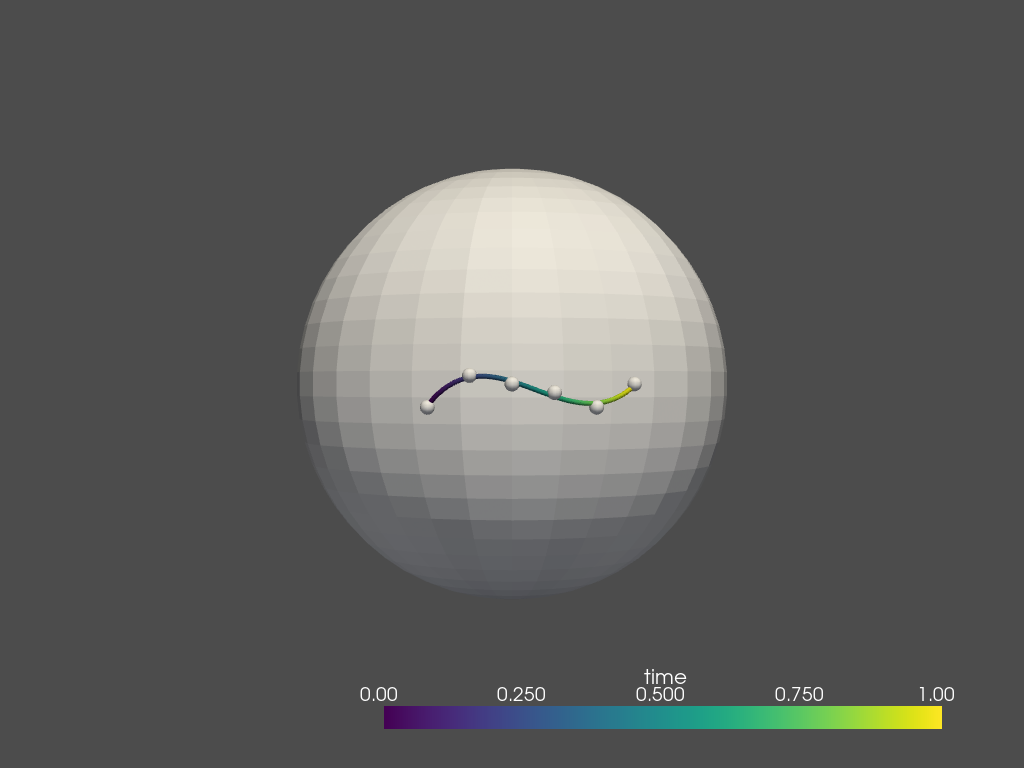

In [6]:
"""Plot best-fitting cubic Bézier in SO(3) (on Sphere)"""

# evaluate the curve at 100 equidistant points
X = jax.vmap(bet.eval)(jnp.linspace(0., 1., num=100))
x = np.asarray(X[...,0].squeeze())

pl = pv.Plotter(notebook=True)
pl.add_mesh(tube_mesh(x))
pl.add_mesh(pv.Sphere(1))

# plot Y
for y in Y:
    pl.add_mesh(pv.Sphere(radius=0.03, center=y[...,0]))

pl.view_yz()
pl.show(jupyter_backend='static')

## Spline regression

Generalized Bézier curves can be joined together in a differentiable way. The resulting _Bézier splines_ are very flexible
and, thus, allow to describe many phenomena. In particular, since there are closed Bézier splines,
they can be used to model cyclic behavior like the motion of the heart.

In [7]:
"""Regression with closed splines for data in SO(3)"""
from scipy.spatial.transform import Rotation

# z-axis is axis of rotation
Rz = jnp.asarray([Rotation.from_rotvec([0, 0, np.pi / 6]).as_matrix()])
# y-axis is axis of rotation
Ry = jnp.asarray([Rotation.from_rotvec([0, np.pi / 6, 0]).as_matrix()])

Y = jnp.array([I, Rz, Ry @ Rz, Ry])

# spline consisting of 2 cubic segments
degree = 3
n_segments = 2

# time points between 0 and 2 because we have two segments
t = jnp.array([1/3, 2/3, 4/3, 5/3])

# solve for closed spline
regression = RiemannianRegression(M, Y, t, degree, n_segments=n_segments, iscycle=True)

# least-squares estimator within the class of closed Bézier splines with two cubic segments
bet = regression.trend

Again, the results can be visualized on the sphere. Note that the computed closed spline interpolates the data points in this case.
The reason for this is that we have only 4 data points and the same number of degrees of freedom. In general though, regression assumes noisy measurements and,
thus, least-squares optimization and not interpolation is the goal.

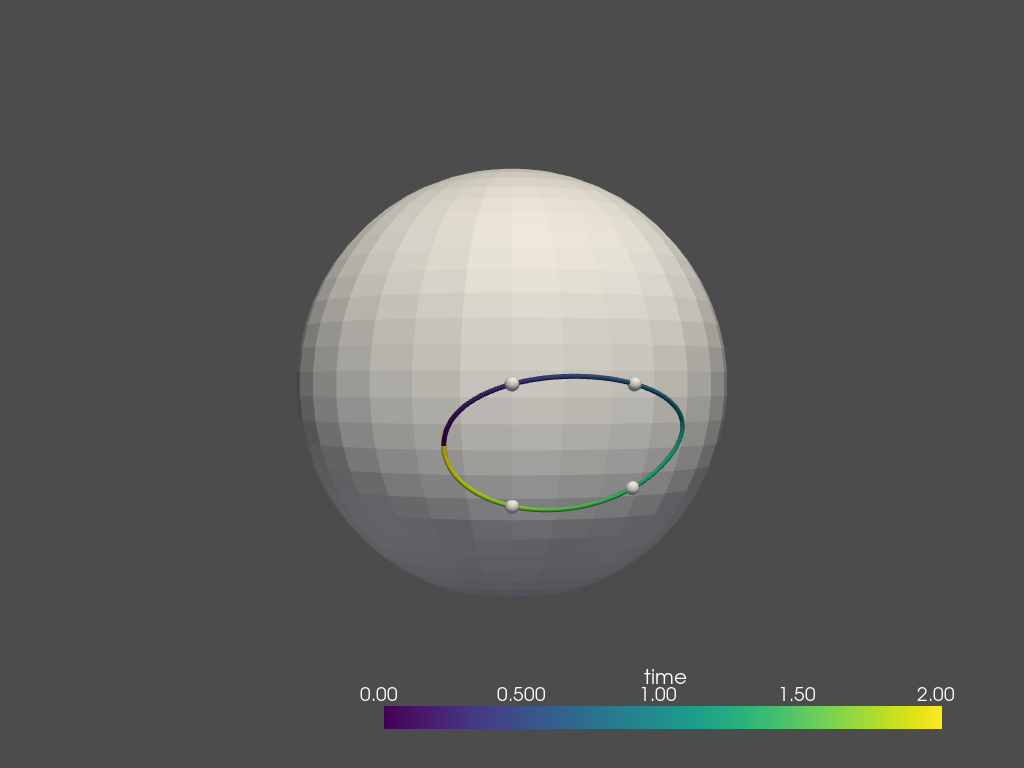

In [8]:
"""Plot closed Bézier spline consisting of 2 cubic segments in SO(3) (on Sphere)"""

# evaluate the spline at 100 equidistant points
interval=(0, bet.nsegments)
X = jax.vmap(bet.eval)(jnp.linspace(*interval, 100))
x = np.asarray(X[...,0].squeeze())

pl = pv.Plotter(notebook=True)
pl.add_mesh(tube_mesh(x, interval))
pl.add_mesh(pv.Sphere(1))

# plot Y
for y in Y:
    pl.add_mesh(pv.Sphere(radius=0.03, center=y[...,0]))

pl.view_yz()
pl.show(jupyter_backend='static')